In [1]:
import torch, torchvision
from torch.utils.cpp_extension import CUDA_HOME; 

#check versions and CUDA
print(torch.__version__)
!gcc --version
print(torch.version.cuda)
print(torch.cuda.is_available(), CUDA_HOME)

1.8.1
gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-44)
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

10.1
True /usr/local/cuda


In [26]:
%load_ext autoreload
%autoreload 2


import numpy as np
import cv2
import os
import random
import matplotlib.pylab as plt
from PIL import Image
import tqdm 
import timeit
from math import floor

import detectron2
print(detectron2.__version__)
import sys
sys.path.append('../')

from Nucleus import ImageInput
from Nucleus import ImageTile
from Nucleus import Stitcher
from detectron2_predict import detectron_predict
from detectron2_predict import detectron_init
from utils import PNG_to_JSON
from Nucleus import coco_nucleus
from Nucleus import get_feature_table_2D

from skimage import io
import tifffile
import glob
import shutil

utils.PNG_to_JSON
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4


# Step 1: get segmentation for all images

1. Pick a single z-plane (if fine z-stack was aquired probably 2-3 planes can be collapsed in a max projection but bear in mind the algorithm was trained on images that do not have overlapping nuclei).

2. Size should multiple of 128 - now there is a check that ensures this by generating a cropped version. 


In [5]:
os.getcwd()

'/nemo/lab/briscoej/home/users/ritot/nucleus_t18/Nucleus/notebooks'

In [6]:
ROOT_PATH = './test_2D/'
os.listdir(ROOT_PATH)

['img']

In [9]:
#there should be a img and masks folders inside ROOT_PATH.
if not os.path.exists(ROOT_PATH+"/img"):
    os.makedirs(ROOT_PATH+"/img")

if not os.path.exists(ROOT_PATH+"/masks"):
        os.makedirs(ROOT_PATH+"/masks")

for file in glob.glob(ROOT_PATH+'/*.tif'):
    shutil.move(file, ROOT_PATH+"/img")

In [33]:
NUCLEAR_Ch = 0 # zero-indexed => 0 corresponds to channel 1 with DAPI staining

#lists all images to be segmented
images_to_segment = os.listdir(ROOT_PATH+"img/")
print(images_to_segment)

['micropattern_zplane.tif', 'mouse_section.tif']


In [12]:
# check images to segment
im_number=0
input_img=images_to_segment[im_number]
im = io.imread(ROOT_PATH+"img/"+input_img)
im =np.moveaxis(im, 0, -1) # uncomment if necessary to get image shape correct. It should be X,Y,Channels . 
print(input_img)
print(im.shape) #should be X,Y,Ch

micropattern_zplane.tif
(1024, 1024, 3)


(-0.5, 1023.5, 1023.5, -0.5)

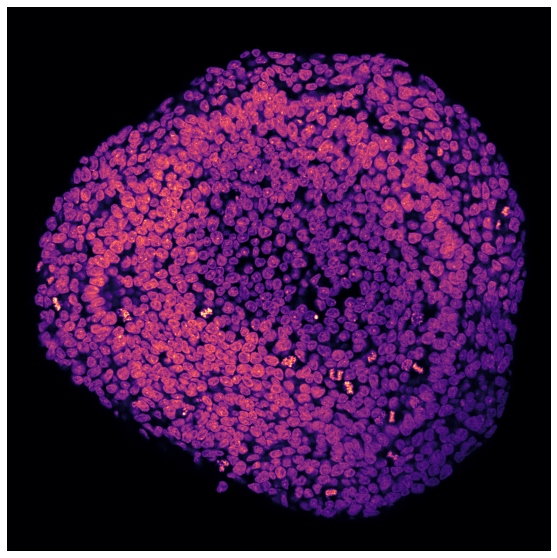

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(im[:,:,0], cmap='magma'); plt.axis('off')

In [78]:
# please uncomment if you need to crop images and make them multiple of 128px 
#
#
# for i in range(0,len(images_to_segment)):
#     input_img = images_to_segment[i]
#     print(input_img)
#     im = io.imread(ROOT_PATH+"img/"+input_img)
#     #im =np.moveaxis(im, 0, -1)
#     print(im.shape)
#     im = im[0:floor(im.shape[0]/128)*128,
#             0:floor(im.shape[1]/128)*128,:]
#     print(im.shape)
    
#     #im = np.expand_dims(im, axis=0)
#     im =np.moveaxis(im, -1, 0)
#     print(im.shape)      #z, channel, x, y 

#     tifffile.imwrite(ROOT_PATH+"img/"+'crop'+input_img,
#             im,
#             imagej=True,
#             photometric='minisblack',
#             planarconfig='contig',
#             #compression='zlib',
#             metadata={'axes': 'CYX'})
#
#images_to_segment = os.listdir(ROOT_PATH+"img/")
#images_to_segment = [x for x in images_to_segment if ("crop" in x)]
#images_to_segment

In [79]:
# please modify model type and directory path to be used

model_type= 'invitro' # 'invitro'  or 'SC_sections'
model_path= '/nemo/lab/briscoej/home/shared/tiagu-models/micropatterns/'

for k in range(0,len(images_to_segment)):    
   
    input_img=images_to_segment[k]
    print("Segmenting image:")
    print(input_img)
    im = io.imread(ROOT_PATH+"img/"+input_img)
    im = np.moveaxis(im, -1, 0)
    print(im.shape) # should be ch,x,y
    

    sz=im[NUCLEAR_Ch,:,:] 
    print(sz.shape)

    one = ImageInput(img_str=sz, step=128) 
    m_tiles, v_tiles, h_tiles = one.make_tiles('stitch_v1')

    
    print("Predicting...")

    pred= detectron_init(model=model_type, model_dir=model_path) 

    tic=timeit.default_timer()
    print("Main_tiles")
    m_out = [detectron_predict(_im,pred) for _im in m_tiles] 
    print("V_tiles")
    v_out = [detectron_predict(_im,pred) for _im in v_tiles]
    print("H_tiles")
    h_out = [detectron_predict(_im,pred) for _im in h_tiles]
    toc=timeit.default_timer()
    
    
    # Stitching
    print("Stitching...")
    tic=timeit.default_timer()
    test = Stitcher(one)
    seg_mask, nuclei_tally = test.stitch_v1([m_tiles,v_tiles,h_tiles] , [m_out, v_out, h_out], margin=6)
    toc=timeit.default_timer()
    print(f'This image has {nuclei_tally} segmented nuclei.')
    
    
    
    # save mask 
    print("Saving...")
    im_seg = Image.fromarray(seg_mask)
    im_seg.save(ROOT_PATH+"masks/"+input_img)
    print("Segm mask saved.")
    
    
    
    # save JSON
    tic=timeit.default_timer()
    PNG_to_JSON.main(ROOT_DIR=ROOT_PATH,
                            image_files=[input_img], 
                            output= ROOT_PATH+"masks/"+ input_img +'_.json') 
    toc=timeit.default_timer()
    print('json saved. The time for saving json was {:.2f} sec'.format(toc - tic))
    
    
    
    
    # save overlay segmentation and image
    segmFile =ROOT_PATH+"masks/"+input_img+'_.json'
    imgDir   = ROOT_PATH+"img/"
    output_imageFile = ROOT_PATH+"masks/z"+input_img+'_coco_out.png'
    pick_image_number=0

    coco=coco_nucleus(segmFile)
    cats = coco.loadCats(coco.getCatIds())
    nms=[cat['name'] for cat in cats]
    print('COCO categories: \n{}\n'.format(' '.join(nms)))
    catIds = coco.getCatIds(catNms=['nucleus']);
    imgIds = coco.getImgIds(catIds=catIds);
    img = coco.loadImgs(imgIds[pick_image_number])[0]

    fig = plt.figure(figsize=(18,18))

    input_img+"_mod.tif"
    I = io.imread(imgDir+img['file_name'])
    I = np.moveaxis(I, -1, 0)
    I = np.asarray(I[NUCLEAR_Ch,:,:]) #[z,:,:,0]


    plt.imshow(I, cmap='magma'); plt.axis('off')
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
    anns = coco.loadAnns(annIds)
    coco.showAnns_Nucleus(anns)
    plt.savefig(output_imageFile,dpi=150,bbox_inches='tight',pad_inches=0)
    plt.close()

    print("saved overlay. All done.")
    print("\n\n\n\n\n")


Segmenting image:
micropattern_zplane.tif
(3, 1024, 1024)
(1024, 1024)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 1467 segmented nuclei.
Saving...
Segm mask saved.
./test_2D/
None
./test_2D/masks/micropattern_zplane.tif_.json
Supply z-slice of original image. zero if none.
micropattern_zplane.tif
(1024, 1024, 3)
1449


The time for annotation info was 8.25 sec
Done saving JSON!
json saved. The time for saving json was 8.40 sec
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
nucleus

saved overlay. All done.






Segmenting image:
mouse_section.tif
(2, 512, 1024)
(512, 1024)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 588 segmented nuclei.
Saving...
Segm mask saved.
./test_2D/
None
./test_2D/masks/mouse_section.tif_.json
Supply z-slice of original image. zero if none.
mouse_section.tif
(512, 1024, 2)
586


The time for annotation info was 6.24 sec
Done saving JSON!
json saved. The time for saving json was 6.32 sec
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO categories: 
nucleus

saved overlay. All done.








# Get Features Table

In [80]:
import pandas as pd
output_table=ROOT_PATH +"features_table.csv"
output_table

'./test_2D/features_table.csv'

In [81]:
df=[]
print(images_to_segment)
for input_img in images_to_segment:
    print(input_img)
    img = io.imread( ROOT_PATH+"img/"+ input_img )
    print(img.shape) # has to be X, Y, Ch
    
    masks = io.imread(ROOT_PATH+"masks/"+input_img )
    masks = np.array(masks)
    print(masks.shape)
    
    img_df= get_feature_table_2D(input_img, img, masks)
    
    df= df+img_df
    
    
    
Data = pd.DataFrame(df, columns=('Image', 'Instance', 'nuclear_avgs',
                      'area','Elipse_centre','Elipse_major_minor','Elipse_angle',
                             'Centroid',
                            'hood_avgs',
                            'cyto_avgs'))

Data.to_csv(output_table, index=False)

Data

['micropattern_zplane.tif', 'mouse_section.tif']
micropattern_zplane.tif
(1024, 1024, 3)
(1024, 1024)
mouse_section.tif
(512, 1024, 2)
(512, 1024)


,Image,Instance,nuclear_avgs,area,Elipse_centre,Elipse_major_minor,Elipse_angle,Centroid,hood_avgs,cyto_avgs
0,micropattern_zplane.tif,1,"[83.881, 90.174, 26.549]",344,"(427.06396484375, 107.92869567871094)","(14.80236530303955, 27.746732711791992)",70.544960,"(426, 108)","[42.08, 43.102, 12.976]","[29.565, 40.903, 10.384]"
1,micropattern_zplane.tif,2,"[85.258, 58.923, 5.791]",182,"(468.15972900390625, 85.70421600341797)","(14.166789054870605, 15.967225074768066)",55.730366,"(468, 85)","[25.279, 20.838, 6.965]","[21.041, 12.442, 5.034]"
2,micropattern_zplane.tif,3,"[85.098, 42.91, 6.612]",245,"(478.61676025390625, 99.42825317382812)","(14.246146202087402, 21.720796585083008)",82.176910,"(478, 99)","[51.473, 36.434, 14.636]","[32.345, 20.571, 5.983]"
3,micropattern_zplane.tif,4,"[72.591, 117.357, 18.649]",154,"(447.3221130371094, 88.81394958496094)","(8.860384941101074, 20.26386260986328)",60.254005,"(447, 88)","[26.389, 28.864, 7.207]","[14.803, 20.476, 6.503]"
4,micropattern_zplane.tif,5,"[45.111, 37.162, 6.667]",99,"(461.3833312988281, 105.26266479492188)","(9.395339012145996, 14.18452262878418)",75.681396,"(460, 105)","[52.181, 45.017, 14.211]","[28.528, 21.122, 6.415]"
...,...,...,...,...,...,...,...,...,...,...
1971,mouse_section.tif,583,"[102.073, 12.931]",655,"(920.032470703125, 366.02301025390625)","(19.759750366210938, 41.28857421875)",9.904113,"(919, 366)","[83.93, 12.973]","[32.918, 10.065]"
1972,mouse_section.tif,584,"[126.022, 17.963]",801,"(947.06005859375, 376.0779113769531)","(26.97946548461914, 37.88252639770508)",155.757111,"(947, 375)","[64.859, 13.567]","[47.356, 14.31]"
1973,mouse_section.tif,585,"[133.615, 15.851]",944,"(879.3018798828125, 371.0150146484375)","(32.10783767700195, 35.83987808227539)",35.393353,"(879, 371)","[91.959, 12.487]","[46.66, 10.117]"
1974,mouse_section.tif,586,"[66.337, 12.469]",273,"(992.4337158203125, 387.2618713378906)","(17.20257568359375, 18.781282424926758)",109.301064,"(992, 387)","[67.739, 13.416]","[39.35, 11.161]"


In [103]:
## Example analysis

output_table=ROOT_PATH +"features_table.csv"

Data = pd.read_csv(output_table)


df=Data[Data.Image=='micropattern_zplane.tif'].copy()

In [104]:
def robust_min_max(X, _min, _max):
    X_max_top = np.mean(X[X>np.percentile(X, 99)])
    X_std = (X - X.min(axis=0)) / (X_max_top  - X.min(axis=0))
    X_scaled = X_std * (_max - _min) + _min
    return X_scaled



df['Centroid'] = [eval(x) for x in df['Centroid']]
df['Centroid_x'] = [x0 for x0,x1 in df['Centroid'] ] # already switched y,x
df['Centroid_y'] = [x1 for x0,x1 in df['Centroid'] ]


df['nuclear_avgs'] = [eval(x) for x in df['nuclear_avgs']]

#assign channels according to experiment
df['DAPI'] = [x[0] for x in df['nuclear_avgs']]
df['ch1'] = [x[1] for x in df['nuclear_avgs']]
df['ch2'] = [x[2] for x in df['nuclear_avgs']]

df['ch1_norm_dapi'] = robust_min_max(np.asarray(df['ch1']/df['DAPI']),0,1)
df['ch12_norm_dapi'] = robust_min_max(np.asarray(df['ch2']/df['DAPI']),0,1)

df['ch1_norm'] = robust_min_max(np.asarray(df['ch1']),0,1)
df['ch2_norm'] = robust_min_max(np.asarray(df['ch2']),0,1)

(0.0, 1000.0)

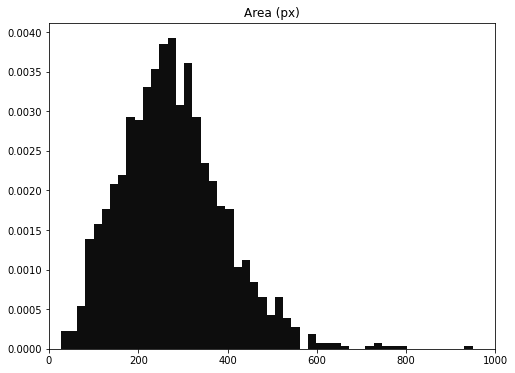

In [107]:
plt.figure(figsize=(8,6))
plt.hist(df['area'], 50, density=True, facecolor='black', alpha=0.95)
plt.title('Area (px)')
plt.xlim(0,1000)

In [ ]:
#subset df based on area
df= df[ df.area>40 ]
df= df[ df.area<500 ]

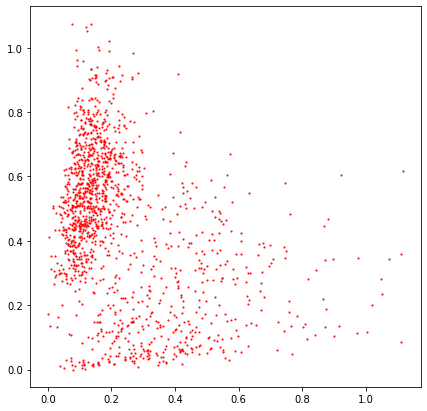

In [108]:
plt.figure( figsize=(7,7))
plt.scatter(df.ch1_norm, df.ch2_norm,  alpha=0.8, s=1.5 , c='red')

mouse_section.tif
(1024, 1024, 3)
0


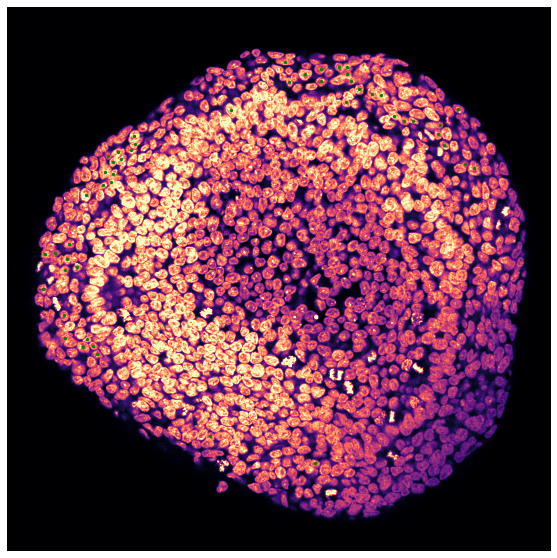

1


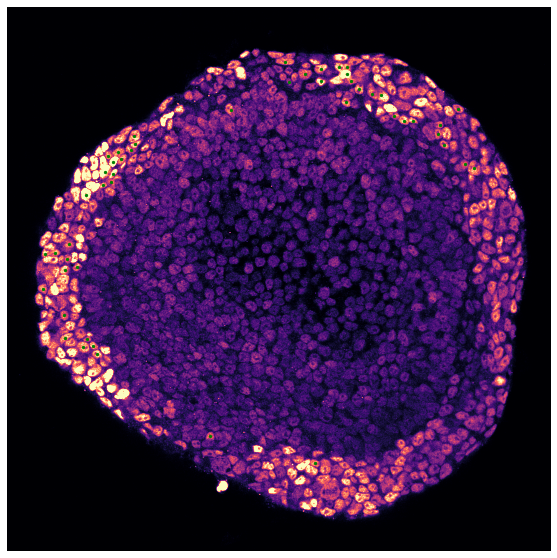

2


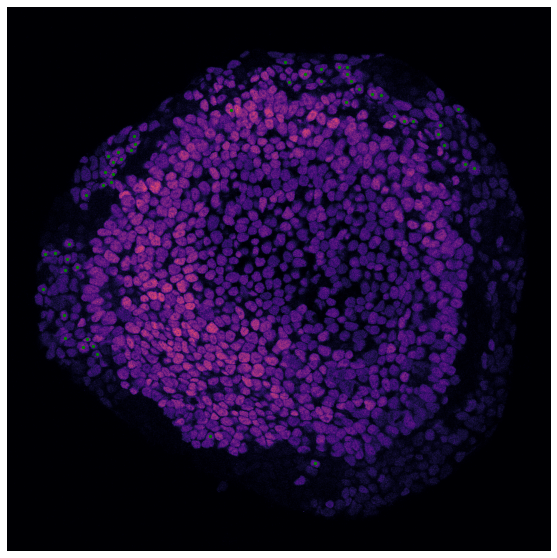

In [117]:
#plot locations of cells of interest

# define cells of interest
df['manual_thres']= [1 if (x>0.4)&(y>0.4) else 0 for x,y in zip(df.ch1_norm,df.ch2_norm) ]                                                                                                                                  



im = io.imread(ROOT_PATH+"img/"+df.Image[0])
print(input_img)
print(im.shape) #should be X,Y,Ch


channel_name_=['manual_thres']
ch_=[0,1,2]

#check an image


for j in ch_:
    ch=j
    print(j)


    xx = [(x[0],x[1]) for x in zip(df['Centroid_x'],df['Centroid_y'], df[channel_name]) if x[2]==1]


    plt.figure(figsize=(10,10))
    plt.imshow(im[:,:,ch], cmap='magma',vmax=150); plt.axis('off')

    if len(xx)>0:
        xx2,yy2=list(zip(*xx)) #they are flipped!
        plt.scatter( np.asarray(xx2) ,  np.asarray(yy2) ,alpha=1, c='green',s=5)

    plt.show()